In [1]:
import numpy as np
import plotly.graph_objects as go
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from typing import List, Union
import scipy.optimize as spo
from collections import Counter

In [2]:
class Fiber_cylinder:
    def __init__(self, core_r = 0, clad_r = 0, core_n = 0, clad_n = 0, z_max = 0, diffusion = None):
        self.diffusion = diffusion
        self.core_r = core_r
        self.clad_r = clad_r
        self.core_n = core_n
        self.clad_n = clad_n
        self.z_max = z_max
    def set_geometry(self, core_r, clad_r, z): #радиусы принимаются в метрах
        self.core_r = core_r
        self.clad_r = clad_r
        self.z_max = z
    def set_refr(self, core_n, clad_n):
        self.core_n = core_n
        self.clad_n = clad_n
    def radius(self):
        return self.core_r, self.clad_r
    def refr(self):
        return self.core_n, self.clad_n
    def find_normal(self, intersection_point):
        x, y = intersection_point[:2]
        result = -1 * np.array([x, y, 0])/np.sqrt(x**2 + y**2)
        return result # Возвращает нормаль к поверхности, направленную к центру цилиндра

class Fiber_cone:
    def __init__(self, z_max = 1.0, base_r = 0.0, top_r = 0.0, core_n = 1.445, clad_n = 1.44, diffusion = None):       
        self.diffusion = diffusion
        self.z_max = z_max
        self.angle = np.arcsin((base_r - top_r) / z_max)
        self.base_r = base_r
        self.top_r = top_r
        self.c = np.sin(self.angle) / np.cos(self.angle)
        self.core_n = core_n
        self.clad_n = clad_n
    def set_geometry(self, z_max = 1, base_r = 0, top_r = 0):
        self.base_r = base_r
        self.top_r = top_r
        self.angle = np.arcsin((base_r - top_r) / z_max)
        self.z_max = z_max
        self.c = np.sin(self.angle) / np.cos(self.angle)
    def set_refr(self, core_n, clad_n):      
        self.core_n = core_n
        self.clad_n = clad_n
    def refr(self):    
        return self.core_n, self.clad_n
    def find_normal(self, intersection_point):     
        x, y = intersection_point[:2]
        z = -self.c**2*(intersection_point[2] - self.base_r / self.c)
        result = -1 * np.array([x, y, z])/np.sqrt(x**2 + y**2 + z**2)
        return result # Возвращает нормаль к поверхности, направленную к центру конуса
    def find_radius(self, z):
        return self.base_r - (self.base_r - self.top_r) / self.z_max * z 

In [3]:
class Ray_pair_cone:
    def __init__(self, azimut = 0, latitude = 0, startpoint = [0,0,0], transmission = 0.8): #все углы принимаются в радианах
        self.cdf = None
        self.angles = None
        self.index = True
        self.azimut = azimut
        self.latitude = latitude
        self.startpoint = startpoint
        self.vector = [np.sin(latitude)*np.cos(azimut),
                      np.sin(latitude)*np.sin(azimut), 
                      np.cos(latitude)]
        self.transmission = transmission
    
    def set_values(self, azimut, latitude, startpoint):
        self.azimut = azimut
        self.latitude = latitude
        self.startpoint = startpoint
        self.vector = [np.sin(latitude)*np.cos(azimut),
                      np.sin(latitude)*np.sin(azimut), 
                      np.cos(latitude)]
    def calculate_angles_from_vector(self, vector):
        latitude = np.arccos(vector[2])
        if latitude == 0:
            return [0, 0]
        cos = vector[0] / np.linalg.norm(vector[:2])
        sin = vector[1] / np.linalg.norm(vector[:2])
        if sin > 0:
            azimut = np.arccos(cos)
        else:
            azimut = -np.arccos(cos)
        return [azimut, latitude]
    
    def calculate_intersection_cylinder(self, core_radius):
        if self.latitude == 0:
            return [*self.startpoint[:2], -1]
        x0, y0, z0 = self.startpoint
        phi, alpha = self.azimut, self.latitude
        R = core_radius
        gamma = np.cos(phi)*x0 + np.sin(phi)*y0
        if gamma**2 - x0**2 - y0**2 + R**2 >= 0:
            x = x0 + np.cos(phi) * (-gamma + np.sqrt(gamma**2 - x0**2 - y0**2 + R**2))
            y = y0 + np.sin(phi) * (-gamma + np.sqrt(gamma**2 - x0**2 - y0**2 + R**2))
            z = z0 + np.cos(alpha) / np.sin(alpha) * (-gamma + np.sqrt(gamma**2 - x0**2 - y0**2 + R**2))

            return [x, y, z]
        else:
            return None
    
    def calculate_intersection_cone(self, base_radius, c):
        a = base_radius/c
        if self.latitude == 0:
            return [*self.startpoint[:2], -1]
        x0, y0, z0 = self.startpoint
        phi, alpha = self.azimut, self.latitude
        gamma = np.cos(phi)*x0 + np.sin(phi)*y0
        A = np.sin(alpha)**2 - np.cos(alpha)**2 * c**2
        B = np.sin(alpha) * gamma - np.cos(alpha) * (z0 - a) * c**2
        C = x0**2 + y0**2 - c**2 * (z0 - a)**2
        t = (-B + np.sqrt(B**2 - A * C)) / A
        x = x0 + np.cos(phi) * np.sin(alpha) * t
        y = y0 + np.sin(phi) * np.sin(alpha) * t
        z = z0 + np.cos(alpha) * t

        return [x, y, z]
    def calculate_reflection(self, point, normal):
        cosine  = np.dot(normal, self.vector)
        angle = np.arccos(abs(cosine))
        proection = normal * cosine
        reflected_vector = -2 * proection + self.vector
        return *self.calculate_angles_from_vector(reflected_vector), angle
    
    def generate_startpoint(self, radius):
        phi = np.random.random() * np.pi
        r = np.random.random() * radius
        coords = [r*np.cos(phi), r*np.sin(phi)]
        self.startpoint = [*coords, 0]
        return [*coords, 0]
    
    def set_startpoint(self, x = 0, y = 0, z = 0):
        self.startpoint = [x, y, z]
        return self.startpoint
    
    def generate_angles(self, max_latitude = 30):
        latitude = np.deg2rad(np.random.random() * max_latitude)
        azimut = np.deg2rad(np.random.random() * 360)
        self.azimut = azimut
        self.latitude = latitude
        self.vector = [np.sin(latitude)*np.cos(azimut),
                      np.sin(latitude)*np.sin(azimut), 
                      np.cos(latitude)]
        return [latitude, azimut]
    def generate_angles_uniform(self, max_latitude = 10, step = 0.1):
        if self.cdf is None:                                                         # Если кумулятивная функция распределения не посчитана
            n = max_latitude / step                                           # Количество точек разбиения
            self.angles = np.linspace(0, np.deg2rad(max_latitude), int(n))    # Массив углов с осью 
            solid_angles = np.array([2*np.pi*(1-np.cos(x)) for x in self.angles])  # Массив телесных углов
            solid_angles_diff = np.diff(solid_angles)                         # Массив производных телесных углов
            pdf = solid_angles_diff / sum(solid_angles_diff)                  # Функция плотности вероятности
            self.cdf = np.array([np.sum(pdf[:i]) for i in range(len(pdf)+1)]) # Кумулятивная функция плотности распределения
        self.azimut = np.deg2rad(np.random.random() * 360)
        rand = np.random.random()
        index = 0
        for i, c in enumerate(self.cdf):
            if c > rand:
                index = i
                break
        self.latitude = self.angles[index] # Обратная cdf # Обратная cdf
        self.vector = [np.sin(self.latitude)*np.cos(self.azimut),
                      np.sin(self.latitude)*np.sin(self.azimut), 
                      np.cos(self.latitude)]
        self.index = True
        return [self.azimut, self.latitude]

    def set_angles(self, azimut, latitude):
        self.azimut = azimut
        self.latitude = latitude
        self.vector = [np.sin(latitude)*np.cos(azimut),
                      np.sin(latitude)*np.sin(azimut), 
                      np.cos(latitude)]
        return [latitude, azimut]
    
    def calculate_trajectory(self, fiber1, fiber2, max_reflection = 1000, angle_elimination = True, output = False):
        z_max = fiber1.z_max
        termination_angle = np.arcsin(fiber1.clad_n / fiber1.core_n)
        Dots = np.zeros((max_reflection, 3))
        reflection_angle = self.latitude
        Angles = np.zeros((max_reflection, 3))
        indexes = np.zeros(max_reflection)
        z_start = self.startpoint[2]
        indexes[0] = self.index
        Dots[0] = self.startpoint
        Angles[0] = [self.azimut, self.latitude, 0]
        for i in range(1, max_reflection):
            if self.index:
                intersection_point = self.calculate_intersection_cylinder(fiber1.core_r)
            else:
                intersection_point = self.calculate_intersection_cone(fiber2.base_r, fiber2.c)
            if intersection_point[0] > fiber1.core_r * self.transmission and self.index == True:
                indexes[i] = self.index
                self.index = False
                Dots[i] = intersection_point
                Dots[i][0] *= 0.8
                Angles[i] = [self.azimut, self.latitude, 0]
                i += 1
                if i == max_reflection:
                    continue
                indexes[i] = self.index
                Dots[i] = intersection_point
                Dots[i][0] *= -0.8 / fiber1.core_r * fiber2.find_radius(Dots[i][2])
                Dots[i][1] *= fiber2.find_radius(Dots[i][2]) / fiber1.core_r
                Angles[i] = [self.azimut, self.latitude + fiber2.angle, 0]
                self.set_values(self.azimut, self.latitude + fiber2.angle, Dots[i])
                continue
            elif intersection_point[0] < fiber2.find_radius(intersection_point[2]) * -self.transmission and self.index == False:
                indexes[i] = self.index
                self.index = True
                Dots[i] = intersection_point
                Dots[i][0] *= self.transmission
                Angles[i] = [self.azimut, self.latitude, 0]
                i += 1
                if i == max_reflection:
                    continue
                indexes[i] = self.index
                Dots[i] = intersection_point
                Dots[i][0] *= -self.transmission * fiber1.core_r / fiber2.find_radius(Dots[i][2])
                Dots[i][1] *= fiber1.core_r / fiber2.find_radius(Dots[i][2])
                Angles[i] = [self.azimut, self.latitude - fiber2.angle, 0]
                self.set_values(self.azimut, self.latitude - fiber2.angle, Dots[i])
                continue
            if intersection_point[2] > z_max:
                intersection_final = intersection_point - self.vector / self.vector[2] * (intersection_point[2] - z_max) 
                Dots[i] = intersection_final
                Angles[i] = [self.azimut, self.latitude, abs(reflection_angle)]
                indexes[i] = self.index
                if output:
                    print('Ray reached z_max.')
                self.index=True
                return Dots, np.rad2deg(Angles), i + 1, 'z_max', indexes
            if self.index:
                normal = fiber1.find_normal(intersection_point)
            else:
                normal = fiber2.find_normal(intersection_point)
            azimut, latitude, reflection_angle = self.calculate_reflection(intersection_point, normal)
            if fiber1.diffusion:
                azimut += (np.random.random() - 0.5 ) * 2 * fiber1.diffusion
                latitude += (np.random.random() - 0.5 ) * 2 * fiber1.diffusion
            Dots[i] = intersection_point
            Angles[i] = [azimut, latitude, abs(reflection_angle)]
            indexes[i] = self.index
            if angle_elimination:
                
                if abs(reflection_angle) < termination_angle:
                    if output:
                        print('Ray terminated, termination angle: ', np.rad2deg(termination_angle),' reflection_angle: ',  np.rad2deg(reflection_angle))
                    self.index=True
                    return Dots, np.rad2deg(Angles), i + 1, 'reflection_angle', indexes
            self.set_values(azimut, latitude, intersection_point)
        if output:
            print('Reflections exceeded', max_reflection)
        self.index=True
        return Dots, np.rad2deg(Angles), max_reflection, 'max_reflections', indexes

In [4]:
class Ray_pair_cylinder:
    def __init__(self, azimut = 0, latitude = 0, startpoint = [0,0,0]): #все углы принимаются в радианах
        self.cdf = None
        self.angles = None
        self.index = True
        self.azimut = azimut
        self.latitude = latitude
        self.startpoint = startpoint
        self.vector = [np.sin(latitude)*np.cos(azimut),
                      np.sin(latitude)*np.sin(azimut), 
                      np.cos(latitude)]
    
    def set_values(self, azimut, latitude, startpoint):
        self.azimut = azimut
        self.latitude = latitude
        self.startpoint = startpoint
        self.vector = [np.sin(latitude)*np.cos(azimut),
                      np.sin(latitude)*np.sin(azimut), 
                      np.cos(latitude)]
    def calculate_angles_from_vector(self, vector):
        latitude = np.arccos(vector[2])
        if latitude == 0:
            return [0, 0]
        cos = vector[0] / np.linalg.norm(vector[:2])
        sin = vector[1] / np.linalg.norm(vector[:2])
        if sin > 0:
            azimut = np.arccos(cos)
        else:
            azimut = -np.arccos(cos)
        return [azimut, latitude]
    
    def calculate_intersection(self, core_radius):
        if self.latitude == 0:
            return [*self.startpoint[:2], -1]
        x0, y0, z0 = self.startpoint
        phi, alpha = self.azimut, self.latitude
        R = core_radius
        gamma = np.cos(phi)*x0 + np.sin(phi)*y0
        if gamma**2 - x0**2 - y0**2 + R**2 >= 0:
            x = x0 + np.cos(phi) * (-gamma + np.sqrt(gamma**2 - x0**2 - y0**2 + R**2))
            y = y0 + np.sin(phi) * (-gamma + np.sqrt(gamma**2 - x0**2 - y0**2 + R**2))
            z = z0 + np.cos(alpha) / np.sin(alpha) * (-gamma + np.sqrt(gamma**2 - x0**2 - y0**2 + R**2))

            return [x, y, z]
        else:
            return None
    def find_chord_length(self, core_radius):
        if self.latitude == 0:
            return np.inf
        x0, y0, z0 = self.startpoint
        phi, alpha = self.azimut, self.latitude
        R = core_radius
        gamma = np.cos(phi)*x0 + np.sin(phi)*y0
        if gamma**2 - x0**2 - y0**2 + R**2 > 0:
            x1 = x0 + np.cos(phi) * (-gamma + np.sqrt(gamma**2 - x0**2 - y0**2 + R**2))
            y1 = y0 + np.sin(phi) * (-gamma + np.sqrt(gamma**2 - x0**2 - y0**2 + R**2))
            z1 = z0 + np.cos(alpha) / np.sin(alpha) * (-gamma + np.sqrt(gamma**2 - x0**2 - y0**2 + R**2))
            x2 = x0 + np.cos(phi) * (-gamma - np.sqrt(gamma**2 - x0**2 - y0**2 + R**2))
            y2 = y0 + np.sin(phi) * (-gamma - np.sqrt(gamma**2 - x0**2 - y0**2 + R**2))
            z2 = z0 + np.cos(alpha) / np.sin(alpha) * (-gamma + np.sqrt(gamma**2 - x0**2 - y0**2 + R**2))
            return np.sqrt((x1-x2)**2 + (y1-y2)**2 + (z1-z2)**2)
        else:
            return None
        
    def consumption(self, ppm, length):
        N = ppm * 6.62e22
        sigma = 1.4e-24
        probability = 1-np.exp(-N*sigma*length)
        rand = np.random.random()
        if rand < probability:
            return True
        else:
            return False
        
    def calculate_reflection(self, point, normal):
        cosine  = np.dot(normal, self.vector)
        angle = np.arccos(abs(cosine))
        proection = normal * cosine
        reflected_vector = -2 * proection + self.vector
        return *self.calculate_angles_from_vector(reflected_vector), angle
    
    def generate_startpoint(self, radius):
        phi = np.random.random() * np.pi
        r = np.random.random() * radius
        coords = [r*np.cos(phi), r*np.sin(phi)]
        self.startpoint = [*coords, 0]
        return [*coords, 0]
    
    def set_startpoint(self, x = 0, y = 0, z = 0):
        self.startpoint = [x, y, z]
        return self.startpoint
    
    def generate_angles(self, max_latitude = 30):
        latitude = np.deg2rad(np.random.random() * max_latitude)
        azimut = np.deg2rad(np.random.random() * 360)
        self.azimut = azimut
        self.latitude = latitude
        self.vector = [np.sin(latitude)*np.cos(azimut),
                      np.sin(latitude)*np.sin(azimut), 
                      np.cos(latitude)]
        return [latitude, azimut]
    def generate_angles_uniform(self, max_latitude = 10, step = 0.1):
        if self.cdf is None:                                                         # Если кумулятивная функция распределения не посчитана
            n = max_latitude / step                                           # Количество точек разбиения
            self.angles = np.linspace(0, np.deg2rad(max_latitude), int(n))    # Массив углов с осью 
            solid_angles = np.array([2*np.pi*(1-np.cos(x)) for x in self.angles])  # Массив телесных углов
            solid_angles_diff = np.diff(solid_angles)                         # Массив производных телесных углов
            pdf = solid_angles_diff / sum(solid_angles_diff)                  # Функция плотности вероятности
            self.cdf = np.array([np.sum(pdf[:i]) for i in range(len(pdf)+1)]) # Кумулятивная функция плотности распределения
        self.azimut = np.deg2rad(np.random.random() * 360)
        rand = np.random.random()
        index = 0
        for i, c in enumerate(self.cdf):
            if c > rand:
                index = i
                break
        self.latitude = self.angles[index] # Обратная cdf # Обратная cdf
        self.vector = [np.sin(self.latitude)*np.cos(self.azimut),
                      np.sin(self.latitude)*np.sin(self.azimut), 
                      np.cos(self.latitude)]
        self.index = True
        return [self.azimut, self.latitude]

    def set_angles(self, azimut, latitude):
        self.azimut = azimut
        self.latitude = latitude
        self.vector = [np.sin(latitude)*np.cos(azimut),
                      np.sin(latitude)*np.sin(azimut), 
                      np.cos(latitude)]
        return [latitude, azimut]
    
    def calculate_trajectory(self, fiber1, fiber2, max_reflection = 1000, angle_elimination = True, output = False):
        z_max = fiber1.z_max
        termination_angle = np.arcsin(fiber1.clad_n / fiber1.core_n)
        Dots = np.zeros((max_reflection, 3))
        reflection_angle = self.latitude
        Angles = np.zeros((max_reflection, 3))
        indexes = np.zeros(max_reflection)
        z_start = self.startpoint[2]
        indexes[0] = self.index
        Dots[0] = self.startpoint
        Angles[0] = [self.azimut, self.latitude, 0]
        for i in range(1, max_reflection):
            if self.index:
                intersection_point = self.calculate_intersection(fiber1.core_r)
            else:
                intersection_point = self.calculate_intersection(fiber2.core_r)
#                 intersection_core = self.calculate_intersection(fiber_core.core_r)
#                 if intersection_core:
#                     length = self.find_chord_length(fiber_core.core_r)
#                     if self.consumption(400, length):
#                         Dots[i] = intersection_core
#                         Angles[i] = [self.azimut, self.latitude, 0]
#                         indexes[i] = self.index
#                         if output:
#                             print('Ray consumed by core')
#                         return Dots, np.rad2deg(Angles), i + 1, 'consumption', indexes
            if intersection_point[0] > fiber1.core_r * 0.8 and self.index == True:
                indexes[i] = self.index
                self.index = False
                Dots[i] = intersection_point
                Dots[i][0] *= 0.8
                Angles[i] = [self.azimut, self.latitude, 0]
                i += 1
                if i == max_reflection:
                    continue
                indexes[i] = self.index
                Dots[i] = intersection_point
                Dots[i][0] *= -0.8 / fiber1.core_r * fiber2.core_r
                Dots[i][1] *= fiber2.core_r / fiber1.core_r
                Angles[i] = [self.azimut, self.latitude, 0]
                self.set_values(self.azimut, self.latitude, Dots[i])
                continue
            elif intersection_point[0] < fiber2.core_r * -0.8 and self.index == False:
                indexes[i] = self.index
                self.index = True
                Dots[i] = intersection_point
                Dots[i][0] *= 0.8
                Angles[i] = [self.azimut, self.latitude, 0]
                i += 1
                if i == max_reflection:
                    continue
                indexes[i] = self.index
                Dots[i] = intersection_point
                Dots[i][0] *= -0.8 * fiber1.core_r / fiber2.core_r
                Dots[i][1] *= fiber1.core_r / fiber2.core_r
                Angles[i] = [self.azimut, self.latitude, 0]
                self.set_values(self.azimut, self.latitude, Dots[i])
                continue
            if intersection_point[2] > z_max:
                intersection_final = intersection_point - self.vector / self.vector[2] * (intersection_point[2] - z_max) 
                Dots[i] = intersection_final
                Angles[i] = [self.azimut, self.latitude, abs(reflection_angle)]
                indexes[i] = self.index
                if output:
                    print('Ray reached z_max.')
                self.index=True
                return Dots, np.rad2deg(Angles), i + 1, 'z_max', indexes
            if self.index:
                normal = fiber1.find_normal(intersection_point)
            else:
                normal = fiber2.find_normal(intersection_point)
            azimut, latitude, reflection_angle = self.calculate_reflection(intersection_point, normal)
            if fiber1.diffusion:
                azimut += (np.random.random() - 0.5 ) * 2 * fiber1.diffusion
                latitude += (np.random.random() - 0.5 ) * 2 * fiber1.diffusion
            Dots[i] = intersection_point
            Angles[i] = [azimut, latitude, abs(reflection_angle)]
            indexes[i] = self.index
            if angle_elimination:
                if abs(reflection_angle) < termination_angle:
                    if output:
                        print('Ray terminated, termination angle: ', np.rad2deg(termination_angle),' reflection_angle: ',  np.rad2deg(reflection_angle))
                    self.index=True
                    return Dots, np.rad2deg(Angles), i + 1, 'reflection_angle', indexes
            self.set_values(azimut, latitude, intersection_point)
        if output:
            print('Reflections exceeded', max_reflection)
        self.index=True
        return Dots, np.rad2deg(Angles), max_reflection, 'max_reflections', indexes

In [5]:
def calculate_multiple_trajectories_pair_cone(fiber1, fiber2, trajectory_count = 100, max_reflection = 1000, output = False, angle = 8, startpoints = None, startangles = None, startindexes=None):
    trajectories = np.zeros((trajectory_count, max_reflection, 3))
    angles = np.zeros((trajectory_count, max_reflection, 3))
    indexes = np.zeros((trajectory_count, max_reflection))
    reflections = np.zeros(trajectory_count)
    termination = ["" for x in range(trajectory_count)] # 0 - max_z, 1 - max_reflection, 2 - reflection angle
    
    for i in tqdm(range(trajectory_count), leave = False):
        ray_internal = Ray_pair_cone()
        if startpoints is not None:
            ray_internal.set_startpoint(*startpoints[i])
        else:
            ray_internal.generate_startpoint(fiber1.core_r)
         
        if startangles is not None:
            ray_internal.set_angles(*startangles[i])
        else:    
            ray_internal.generate_angles_uniform(max_latitude=angle)
        if startindexes is not None:
            ray_internal.index = startindexes[i]
            
            
        trajectories[i], angles[i], reflections[i], termination[i], indexes[i] = ray_internal.calculate_trajectory(fiber1, fiber2, max_reflection=max_reflection, output = output)
    dictionary = {
        'angles':       angles.tolist(),
        'trajectories': trajectories.tolist(),
        'reflections':  reflections.tolist(),
        'termination':  termination,
        'indexes':      indexes.tolist()
    }
    return pd.DataFrame(dictionary)

def calculate_multiple_trajectories_pair_cylinder(fiber1, fiber2, trajectory_count = 100, max_reflection = 1000, output = False, angle = 8, startpoints = None, startangles = None, startindexes = None):
    trajectories = np.zeros((trajectory_count, max_reflection, 3))
    angles = np.zeros((trajectory_count, max_reflection, 3))
    indexes = np.zeros((trajectory_count, max_reflection))
    reflections = np.zeros(trajectory_count)
    termination = ["" for x in range(trajectory_count)] # 0 - max_z, 1 - max_reflection, 2 - reflection angle
    
    for i in tqdm(range(trajectory_count), leave = False):
        ray_internal = Ray_pair_cylinder()
        if startpoints is not None:
            ray_internal.set_startpoint(*startpoints[i])
        else:
            ray_internal.generate_startpoint(fiber1.core_r)
         
        if startangles is not None:
            ray_internal.set_angles(*startangles[i])
        else:    
            ray_internal.generate_angles_uniform(max_latitude=angle)
        if startindexes is not None:
            ray_internal.index = startindexes[i]
            
            
        trajectories[i], angles[i], reflections[i], termination[i], indexes[i] = ray_internal.calculate_trajectory(fiber1, fiber2, max_reflection=max_reflection, output = output)
    dictionary = {
        'angles':       angles.tolist(),
        'trajectories': trajectories.tolist(),
        'reflections':  reflections.tolist(),
        'termination':  termination,
        'indexes':      indexes.tolist()
    }
    return pd.DataFrame(dictionary)

In [6]:
def Extract_finish_data(data):
    data_zm = data[(data['termination'] == 'z_max')].reset_index()
    finish_points = [data_zm['trajectories'][i][int(data_zm['reflections'][i]) - 1] for i in range(len(data_zm))]
    for dot in finish_points:
        dot[2] = 0
    finish_angles = [data_zm['angles'][i][int(data_zm['reflections'][i]) - 1][:2] for i in range(len(data_zm))]
    finish_indexes = [data_zm['indexes'][i][int(data_zm['reflections'][i]) - 1] for i in range(len(data_zm))]
    finish_indexes = 1-np.array(finish_indexes)
    return finish_points, list(np.deg2rad(finish_angles)), finish_indexes

def compose_calculation_pair(
    fiber_composition: List[Union[Fiber_cylinder, Fiber_cone]],
    fiber_pair: List[Union[Fiber_cylinder, Fiber_cone]],
    startpoints: Union[None, List[float]] = None,
    startangles: Union[None, List[float]] = None,
    angle: float = 10,
    output: bool = False,
    trajectory_count: int = 1000,
    max_reflection: int = 2000,
    different_reflections: Union[None, List[int]] = None
) -> List[pd.DataFrame]:
    n_components = len(fiber_composition)
    dataframes = [pd.DataFrame() for i in range(n_components)]
    print('Started calculation, input rays: ', trajectory_count)
    if different_reflections is not None:
        max_reflection = different_reflections[0]
    if startpoints is None:
        dataframes[0] = calculate_multiple_trajectories_pair_cylinder(fiber_composition[0], fiber_pair_composition[0], 
                                                        max_reflection = max_reflection, output = output, 
                                                        trajectory_count = trajectory_count, angle = angle)
    else: 
        dataframes[0] = calculate_multiple_trajectories_pair_cylinder(fiber_composition[0], fiber_pair_composition[0], trajectory_count = len(startpoints), 
                                                        max_reflection = reflections, output = output, startpoints = startpoints,
                                                        startangles = startangles)
    fin_point , fin_angle, fin_index = Extract_finish_data(dataframes[0])
    print('finished calculating element 0, output rays: ', len(fin_point))
    for i in range(1, n_components):
        if different_reflections != None:
            max_reflection = different_reflections[i]
        if type(fiber_composition[i]) is Fiber_cylinder:
            dataframes[i] = calculate_multiple_trajectories_pair_cylinder(
                fiber_composition[i], fiber_pair_composition[i], trajectory_count = len(fin_point), 
                max_reflection = max_reflection, output = output, angle = angle, 
                startpoints = fin_point, startangles = fin_angle, startindexes=fin_index)
        else:
            dataframes[i] = calculate_multiple_trajectories_pair_cone(
                fiber_pair_composition[i], fiber_composition[i], trajectory_count = len(fin_point), 
                max_reflection = max_reflection, output = output, angle = angle, 
                startpoints = fin_point, startangles = fin_angle, startindexes=fin_index)
        fin_point, fin_angle, fin_index = Extract_finish_data(dataframes[i])
        print(f'finished calculating element {i}, output rays: {len(fin_point)}')
    return dataframes
        

In [7]:
diffusion = 0
fiber_1 = Fiber_cylinder(core_r=330e-6/2, clad_r=660e-6, core_n=1.445, clad_n=1.387, z_max=2, diffusion=np.deg2rad(diffusion))
fiber_2 = Fiber_cone(z_max=4, base_r=330e-6/2, top_r=200e-6/2, diffusion=np.deg2rad(diffusion))
fiber_3 = Fiber_cylinder(core_r=200e-6/2, clad_r=400e-6, core_n=1.445, clad_n=1.387, z_max=6, diffusion=np.deg2rad(diffusion))
fiber_4 = Fiber_cone(z_max=4, base_r=200e-6/2, top_r=330e-6/2, diffusion=np.deg2rad(diffusion))
fiber_5 = Fiber_cylinder(core_r=330e-6/2, clad_r=660e-6, core_n=1.445, clad_n=1.387, z_max=2, diffusion=np.deg2rad(diffusion))

fiber_composition = [fiber_1, fiber_2, fiber_3, fiber_4, fiber_5]
fiber_pair_1 = Fiber_cylinder(core_r=62.5e-6, clad_r=660e-6, core_n=1.445, clad_n=1.387, z_max=2)
fiber_pair_2 = Fiber_cylinder(core_r=62.5e-6, clad_r=660e-6, core_n=1.445, clad_n=1.387, z_max=4)
fiber_pair_3 = Fiber_cylinder(core_r=62.5e-6, clad_r=660e-6, core_n=1.445, clad_n=1.387, z_max=6)
fiber_pair_composition = [fiber_pair_1, fiber_pair_2, fiber_pair_3, fiber_pair_2, fiber_pair_1]

In [8]:
dataframes = compose_calculation_pair(
                                      fiber_composition, 
                                      fiber_pair_composition, 
                                      angle = 17,
                                      trajectory_count = int(500), 
                                      different_reflections = [4000, 8000, 15000, 8000, 4000], 
                                      output=False)

Started calculation, input rays:  500


  0%|          | 0/500 [00:00<?, ?it/s]

finished calculating element 0, output rays:  453


  0%|          | 0/453 [00:00<?, ?it/s]

finished calculating element 1, output rays: 259


  0%|          | 0/259 [00:00<?, ?it/s]

finished calculating element 2, output rays: 257


  0%|          | 0/257 [00:00<?, ?it/s]

finished calculating element 3, output rays: 257


  0%|          | 0/257 [00:00<?, ?it/s]

finished calculating element 4, output rays: 256


In [9]:
def find_extermination(data, fiber, show_plot = True, mode = 'cylinder', ret = False):
    data_rt = data[(data['termination'] == 'reflection_angle')].reset_index()
    print(len(data_rt))
    termination_angle = np.deg2rad(90-np.rad2deg(np.arcsin(fiber.clad_n / fiber.core_n)))
    if mode == 'cylinder':
        length = fiber.core_r / np.tan(termination_angle / 2)
    else:
        length = fiber.z_max
    x = np.linspace(0, length, 1000, endpoint=True)
    coordinates = np.array([data_rt['trajectories'][i][data_rt['reflections'][i].astype(int)-1][2] 
                            for i in range(len(data_rt))])
    rays_count = [len(coordinates[coordinates > x[i]]) for i in range(len(x))]
    if show_plot:
        plt.figure(figsize = (12, 8))
        plt.plot(x * 1e3, rays_count)
        plt.xlabel('Coordinates, mm', fontsize = 20)
        plt.ylabel('Ray count', fontsize = 20)
        plt.minorticks_on()
        plt.grid(which="major", linestyle='-', linewidth=1)
        plt.tight_layout()
        plt.show()
    if ret:
        return [x, rays_count]
    return None

46
194
2
0
0


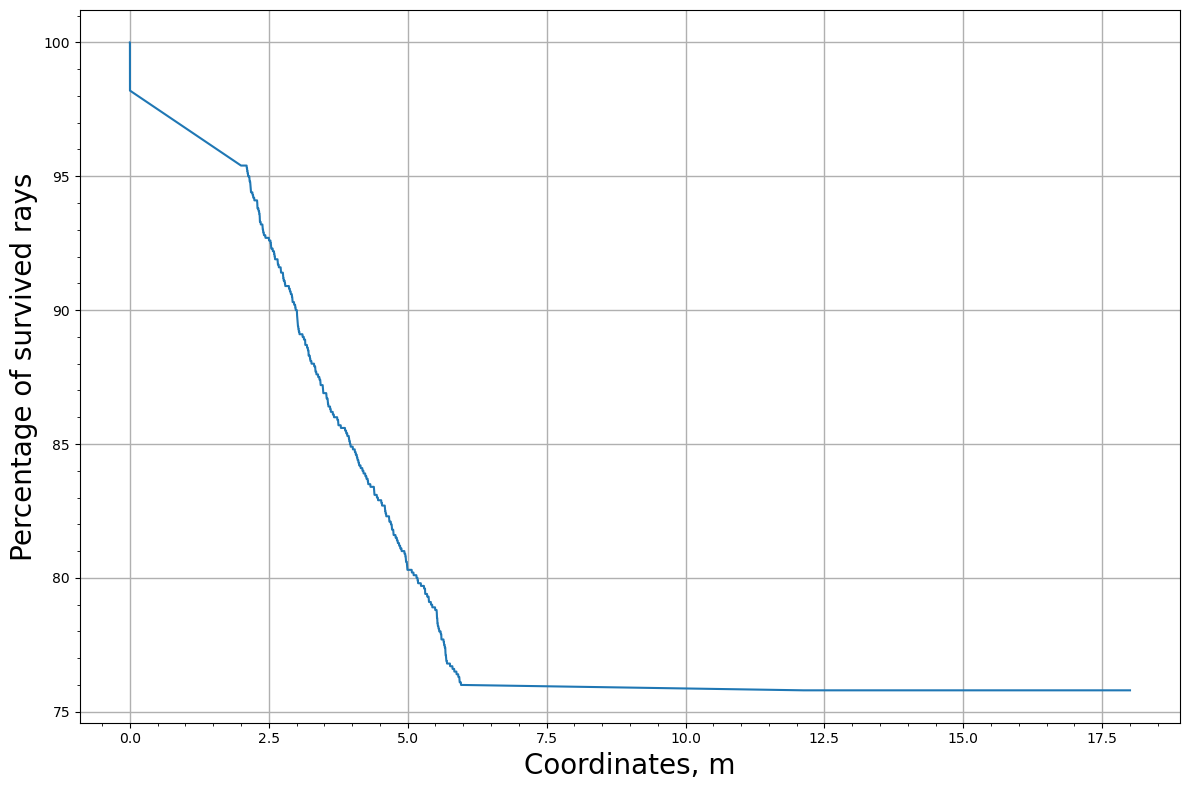

In [10]:
def compose_rays_count(dataframes, fiber_composition, show_plot = True, input_rays = 1000):
    modes = [ 'cone' if isinstance(elem, Fiber_cone) else 'cylinder' for elem in fiber_composition]
    graph_data = [find_extermination(dataframes[i], fiber_composition[i], 
                                     mode = modes[i], ret = True, show_plot = False) for i in range(len(dataframes))]
    x, y = zip(*graph_data)
    x = np.array(x)
    y = np.array(y)
    prev_len = 0
    for i in range(1, len(x)):
        prev_len += fiber_composition[i-1].z_max
        x[i] += prev_len
    x[-1][-1] = prev_len + fiber_composition[-1].z_max
    for i in range(len(y)-2, -1, -1):
        y[i] += y[i+1][0]
    y = (y + (input_rays - y[0][0])) / input_rays * 100
    x = x.flatten()
    y = y.flatten()
    if show_plot:
        plt.figure(figsize = (12, 8))
        plt.plot(x, y)
        plt.xlabel('Coordinates, m', fontsize = 20)
        plt.ylabel('Percentage of survived rays', fontsize = 20)
        plt.minorticks_on()
        plt.grid(which="major", linestyle='-', linewidth=1)
        plt.tight_layout()
        plt.show()
    return None

compose_rays_count(dataframes, fiber_composition)

In [11]:
z_max = np.array([2, 4, 6, 4, 2])
step = 0.1
lens = z_max / step
ray_count = [np.zeros(int(l)-2) for l in lens]
ray_count_2 = [np.zeros(int(l)-2) for l in lens]

for i, z in enumerate(tqdm(z_max)):
    x = np.linspace(0, z, int(z/step))
    data = dataframes[i]
    for j in range(data.shape[0]):
        z_array = [data.trajectories[j][k][2] for k in range(int(data.reflections[j]))]
        for k, coordinate in enumerate(x[1:-1]):
            ind = int(next((z[0] for z in enumerate(z_array) if z[1] > coordinate), -1))
            if ind != -1:
                if data.indexes[j][ind] == True:
                    ray_count[i][k] += 1
                else:
                    ray_count_2[i][k] += 1

  0%|          | 0/5 [00:00<?, ?it/s]

In [12]:
for i in range(1, 5, 2):
    t = ray_count[i]
    ray_count[i] = ray_count_2[i]
    ray_count_2[i] = t
ray_count_final = np.concatenate(ray_count)
ray_count_final_2 = np.concatenate(ray_count_2)

In [13]:
print(ray_count_final)
print(ray_count_final_2)

[330. 332. 324. 323. 335. 345. 325. 326. 320. 323. 340. 327. 334. 328.
 333. 318. 327. 324. 346. 325. 295. 281. 298. 278. 301. 298. 291. 272.
 265. 259. 266. 272. 260. 248. 240. 241. 249. 221. 222. 224. 230. 215.
 207. 206. 212. 198. 200. 204. 187. 198. 190. 171. 173. 164. 161. 158.
 167. 163. 155. 163. 163. 153. 153. 153. 148. 152. 151. 172. 153. 163.
 168. 156. 156. 156. 159. 165. 151. 163. 163. 151. 157. 150. 150. 163.
 149. 159. 172. 157. 163. 167. 148. 150. 148. 155. 160. 157. 161. 158.
 164. 165. 167. 155. 167. 151. 150. 147. 149. 165. 153. 160. 157. 147.
 151. 165. 156. 154. 152. 182. 170. 158. 155. 168. 164. 163. 158. 177.
 165. 159. 174. 158. 164. 172. 176. 180. 187. 172. 181. 179. 168. 178.
 174. 182. 168. 185. 182. 184. 180. 189. 193. 187. 193. 181. 185. 186.
 186. 186. 199. 194. 188. 172. 180. 171. 191. 177. 178. 189. 202. 171.
 189. 185.]
[125. 122. 130. 131. 119. 109. 129. 128. 134. 131. 114. 127. 120. 126.
 121. 136. 127. 130. 107. 118. 142. 146. 127. 140. 113. 110. 112.

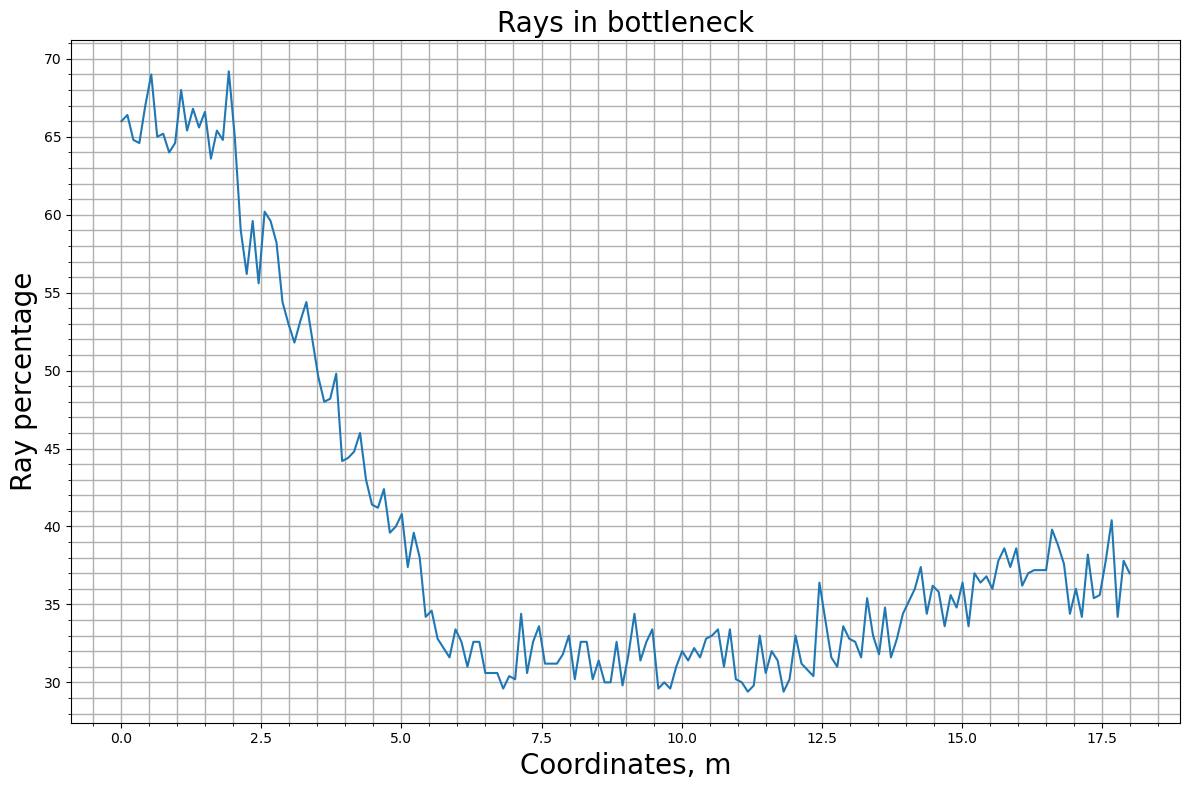

In [14]:
x = np.linspace(0, sum(z_max), ray_count_final.shape[0], endpoint=True)
plt.figure(figsize = (12, 8))
plt.plot(x, np.array(ray_count_final) / dataframes[0].shape[0] * 100)
plt.title('Rays in bottleneck', fontsize=20)
plt.xlabel('Coordinates, m', fontsize = 20)
plt.ylabel('Ray percentage', fontsize = 20)
plt.minorticks_on()
plt.grid(which="both", linestyle='-', linewidth=1)
plt.tight_layout()
plt.show()

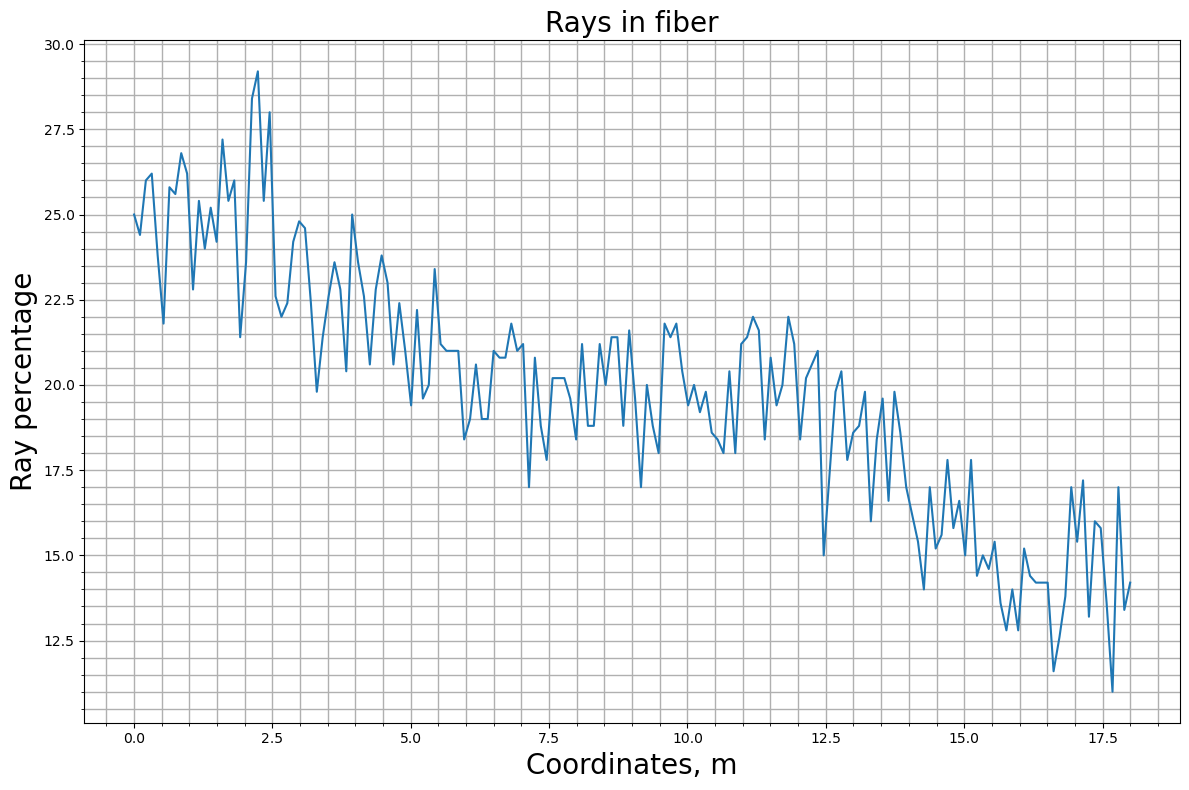

In [15]:
x = np.linspace(0, sum(z_max), ray_count_final.shape[0], endpoint=True)
plt.figure(figsize = (12, 8))
plt.plot(x, np.array(ray_count_final_2) / dataframes[0].shape[0] * 100)
plt.title('Rays in fiber', fontsize=20)
plt.xlabel('Coordinates, m', fontsize = 20)
plt.ylabel('Ray percentage', fontsize = 20)
plt.minorticks_on()
plt.grid(which="both", linestyle='-', linewidth=1)
plt.tight_layout()
plt.show()

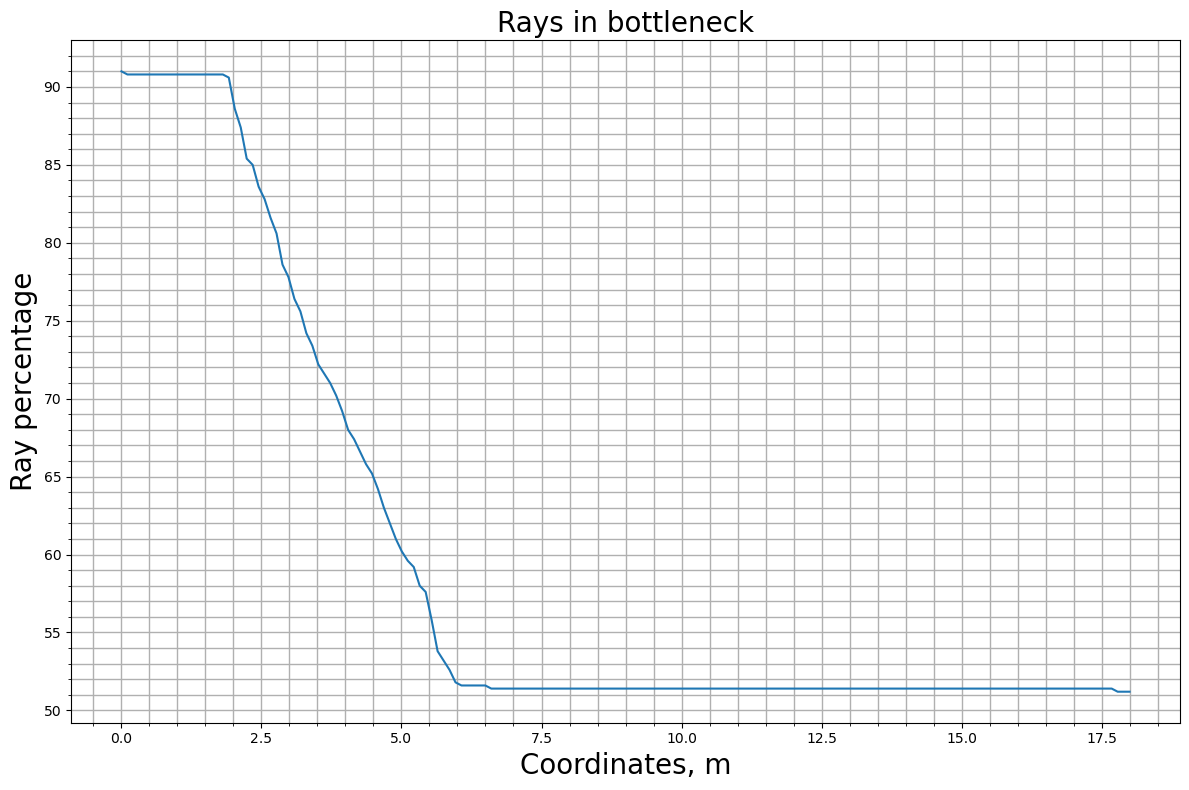

In [16]:
x = np.linspace(0, sum(z_max), ray_count_final.shape[0], endpoint=True)
ray_count_both = np.add(ray_count_final, ray_count_final_2)
plt.figure(figsize = (12, 8))
plt.plot(x, np.array(ray_count_both) / dataframes[0].shape[0] * 100)
plt.title('Rays in bottleneck', fontsize=20)
plt.xlabel('Coordinates, m', fontsize = 20)
plt.ylabel('Ray percentage', fontsize = 20)
plt.minorticks_on()
plt.grid(which="both", linestyle='-', linewidth=1)
plt.tight_layout()
plt.show()